### import

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle as pkl
import os
import math
import time
from datetime import timedelta
import torch
import torch.nn.functional as F
import torch.nn as nn

## Data preprocess

### split trian dev test

see task1

### padding

In [2]:
df_data = pd.read_csv('./raw_data/train.tsv', sep='\t')
df_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df_data['Phrase_len'] = df_data['Phrase'].apply(lambda x: len(x))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

D:\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Phrase_len', ylabel='count'>

([], [])

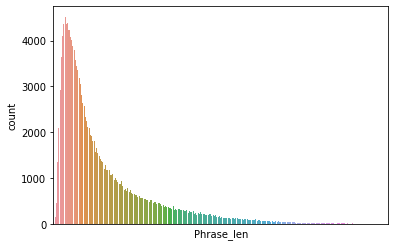

In [5]:
sns.countplot(df_data['Phrase_len'])
plt.xticks([])
plt.show()

D:\anaconda3\envs\nlp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Phrase_len', ylabel='Density'>

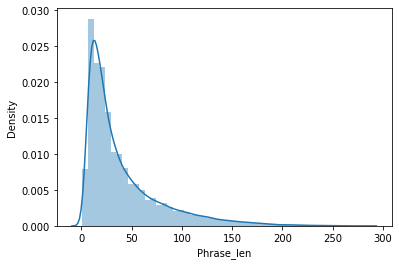

In [6]:
sns.distplot(df_data['Phrase_len']) # plt.hist and sns.kdeplot
plt.show()

In [14]:
pad_size = sorted(df_data['Phrase_len'])[round(len(df_data)*0.95)]
pad_size

122

### build my vocab and dataset

In [2]:
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号

def tokenizer_lemma(line):
    '''
    diff to task 1
    '''
    def get_wordnet_pos(tag):
        '''
        get the part-of-speech
        '''
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN    
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(line.lower())              # 分词,同时大写换小写
    tagged_sent = pos_tag(tokens, tagset='universal')     # 词性标注
    tokens_lemma = [wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_sent]
    return tokens_lemma
    
def build_vocab(data_path, vocab_path):
    data = [_.strip().split('\t')[0] for _ in open(data_path, 'r', encoding='utf-8').readlines()]
    word_cnt = dict()
    for sentence in tqdm(data):
        for token in tokenizer_lemma(sentence):
            word_cnt[token] = word_cnt.get(token, 0) + 1
    word_cnt = sorted(word_cnt.items(), key=lambda x:x[0], reverse=True)
    print(len(word_cnt))
    vocab = {_[0]: idx for idx, _ in enumerate(word_cnt)}
    vocab.update({UNK: len(vocab), PAD: len(vocab) + 1})
    pkl.dump(vocab, open(vocab_path, 'wb'))
    print("vocab build successed, size : %d" %len(vocab))
    return vocab

def build_dataset(config):
    '''
    变成[([],y),([],y),([],y),([],y)]
    '''
    if os.path.exists(config.vocab_path):
        vocab = pkl.load(open(config.vocab_path, 'rb'))
    else:
        vocab = build_vocab(config.train_path, config.vocab_path)
    config.n_vocab = len(vocab)
    print("vocab loaded sucessed, size : %d " %len(vocab))
    def load_data(file_path, output_path, pad_size=config.pad_size):
        if os.path.exists(output_path):
            data = pkl.load(open(output_path, 'rb'))
            print("%s loaded success, size: %d" %(output_path, len(data)))
            return data
        data = open(file_path, 'r', encoding='utf-8').readlines()
        all_data = list()
        for line in tqdm(data):
            try:
                x, y = line.strip().split('\t')
            except:
                print(line)
            tokens = tokenizer_lemma(x)
            if len(tokens) < pad_size:
                tokens.extend([PAD] * (pad_size - len(tokens)))
            else:
                tokens = tokens[:pad_size]
            token_map = [vocab.get(token, vocab.get(UNK)) for token in tokens] # diff to one-hot
            all_data.append((token_map, int(y)))
        pkl.dump(all_data, open(output_path, 'wb'))
        print("%s loaded success, size: %d" %(file_path, len(all_data)))
        return all_data
    test_set = load_data(config.test_path, config.test_set_path)
    dev_set = load_data(config.dev_path, config.dev_set_path)
    train_set = load_data(config.train_path, config.train_set_path)
    return train_set, dev_set, test_set

### glove process

In [3]:
glove_path = r'D:\workspace\pretrained_models\word2vec\standford\glove.6B.300d.txt'
with open(glove_path, 'r', encoding='utf-8') as f:
    vocab = {}
    data = list()
    for i,line in enumerate(f.readlines()):
        w2vlist = line.split()
        word, vector = w2vlist[0], w2vlist[1:]
        vocab[word] = i
        data.append(vector)
    data.append([0]*len(data[0]))
    data.append([0]*len(data[0]))
    vocab.update({UNK: len(vocab), PAD: len(vocab) + 1})
    data = np.array(data,float)
pkl.dump(vocab, open(r'D:\workspace\pretrained_models\word2vec\standford\vocab.pkl', 'wb'))
pkl.dump(data, open(r'D:\workspace\pretrained_models\word2vec\standford\glove.6B.300d.pkl', 'wb'))

KeyboardInterrupt: 

## unit

### config

In [3]:
class Config(object):
    def __init__(self, embed_path=None, vocab_path=None):
        self.train_path = r'./data_set/train.txt'
        self.dev_path = r'./data_set/dev.txt'
        self.test_path = r'./data_set/test.txt'
        self.vocab_path = vocab_path if vocab_path else r'./data_set/vocab.pkl'
        self.train_set_path = r'./data_set/train.pkl'
        self.dev_set_path = r'./data_set/dev.pkl'
        self.test_set_path = r'./data_set/test.pkl'
        self.class_list = [x.strip() for x in open(r'./data_set/labels.txt', encoding='utf-8').readlines()]
        self.label_num = len(self.class_list)
        self.n_vocab = 0    # assign after dataset built
        self.batch_size = 32
        self.epoch = 20
        self.learning_rate = 1e-3
        self.drop_out = 0.3
        self.log_step = 1000
        self.pad_size = 128
        self.embedding_pretrained = torch.FloatTensor(pkl.load(open(embed_path, 'rb'))) if embed_path is not None else None
        self.embedding_len = self.embedding_pretrained.size(1) if self.embedding_pretrained is not None else 300

        self.rnn_hidden = 128
        self.rnn_layer = 2
        self.bi_rnn = False
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
config = Config(embed_path = r'D:\workspace\pretrained_models\word2vec\standford\glove.6B.50d.pkl',
                vocab_path = r'D:\workspace\pretrained_models\word2vec\standford\vocab.pkl')

### datasetIterater

In [5]:
class DatasetIterater(object):
    '''
    return the batch index of dataset
    '''
    def __init__(self, data_set, batch_size, device):
        self.device = device
        self.data_set = data_set
        self.batch_size = batch_size
        self.n_batches = len(data_set) // batch_size
        self.residue = True if len(data_set) % self.n_batches != 0 else False
        self.index = 0
        
    def to_tensor(self, raw_batch):
        x = torch.LongTensor([_[0] for _ in raw_batch]).to(self.device)
        y = torch.LongTensor([_[1] for _ in raw_batch]).to(self.device)
        return x,y
        
    def __next__(self):
        if self.index == self.n_batches and self.residue:
            raw_batch = self.data_set[self.index * self.batch_size: len(self.data_set)]
            batch = self.to_tensor(raw_batch)
            self.index += 1
            return batch
        elif self.index >= self.n_batches:
            self.index = 0
            raise StopIteration
        else:
            raw_batch = self.data_set[self.index * self.batch_size: (self.index+1) * self.batch_size]
            batch = self.to_tensor(raw_batch)
            self.index += 1
            return batch
           
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.n_batches+1 if self.residue else self.n_batches

Test

In [6]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)
data_iter = DatasetIterater(test_set, config.batch_size, config.device)
next(data_iter)

vocab loaded sucessed, size : 14666 
./data_set/test.pkl loaded success, size: 15605
./data_set/dev.pkl loaded success, size: 31211
./data_set/train.pkl loaded success, size: 109242


(tensor([[11304,  4098,  5197,  ..., 14665, 14665, 14665],
         [10453,  7905,  8159,  ..., 14665, 14665, 14665],
         [12066, 14665, 14665,  ..., 14665, 14665, 14665],
         ...,
         [ 8760,  3156, 13399,  ..., 14665, 14665, 14665],
         [14432, 12528,  4100,  ..., 14665, 14665, 14665],
         [12226,  1549,  1729,  ..., 14665, 14665, 14665]], device='cuda:0'),
 tensor([3, 4, 2, 2, 3, 3, 3, 2, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 4,
         2, 2, 3, 2, 2, 2, 1, 2], device='cuda:0'))

## model

### RNN

In [7]:
class Text_RNN(nn.Module):
    def __init__(self, config):
        super(Text_RNN, self).__init__()
        if config.embedding_pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(config.embedding_pretrained, freeze=False, padding_idx=config.n_vocab - 1)
        else:
            self.embedding = nn.Embedding(config.n_vocab, config.embedding_len, padding_idx=config.n_vocab - 1)
        self.rnn = nn.RNN(config.embedding_len, config.rnn_hidden, config.rnn_layer,
                         bidirectional=config.bi_rnn, batch_first=True, dropout=config.drop_out)
        self.fc = nn.Linear(config.rnn_hidden * (int(config.bi_rnn) + 1), config.label_num)
        
    def forward(self, x):
        out = self.embedding(x)
        out, hn = self.rnn(out) # 
        out = self.fc(out[:, -1, :]) # out[:, -1, :] equal to hn[-1, :, :]
        return out

In [8]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)
test_iter = DatasetIterater(test_set, config.batch_size, config.device)
model = Text_RNN(config).to(config.device)
model(next(test_iter)[0])

vocab loaded sucessed, size : 14666 
./data_set/test.pkl loaded success, size: 15605
./data_set/dev.pkl loaded success, size: 31211
./data_set/train.pkl loaded success, size: 109242


tensor([[ 3.7910e-02,  1.5546e-01, -9.2568e-03, -2.2759e-02,  2.7480e-02],
        [-4.4977e-02,  1.0058e-01,  1.2299e-02,  4.2659e-02,  6.3014e-03],
        [-3.5497e-02,  6.0311e-02,  2.4067e-02, -4.9262e-02,  3.5513e-02],
        [ 1.6361e-02,  1.2930e-01,  5.4046e-03,  5.6890e-02,  3.0290e-02],
        [-1.3749e-02,  8.9010e-02, -4.4920e-03, -2.7621e-02, -1.6021e-02],
        [-2.4887e-05,  1.3266e-01, -1.0529e-02, -4.3234e-02, -1.9217e-03],
        [-1.9821e-02,  1.1832e-01,  6.7932e-03, -5.0656e-02,  3.8980e-02],
        [ 8.3512e-03,  1.0779e-01, -1.4798e-02, -1.0075e-02,  3.4323e-03],
        [-2.3932e-02,  5.5860e-02, -7.8181e-03,  7.7881e-03,  3.6686e-02],
        [ 8.5755e-03,  7.8868e-02,  1.8836e-02, -1.0101e-02,  2.5203e-02],
        [-1.9197e-02,  8.6813e-02,  5.5052e-02,  2.5683e-02, -1.8534e-02],
        [-2.4522e-02,  9.8887e-02, -3.3557e-02,  6.6333e-03,  2.4462e-03],
        [-5.3875e-02,  7.4225e-02, -7.5694e-03, -2.3797e-02,  4.8307e-03],
        [-3.8163e-02,  8.

In [9]:
config = Config(embed_path = r'D:\workspace\pretrained_models\word2vec\standford\glove.6B.50d.pkl',
                vocab_path = r'D:\workspace\pretrained_models\word2vec\standford\vocab.pkl')
train_set, dev_set, test_set = build_dataset(config)
test_iter = DatasetIterater(test_set, config.batch_size, config.device)
model = Text_RNN(config).to(config.device)
model(next(test_iter)[0])

vocab loaded sucessed, size : 400002 
./data_set/test.pkl loaded success, size: 15605
./data_set/dev.pkl loaded success, size: 31211
./data_set/train.pkl loaded success, size: 109242


tensor([[-0.0366,  0.0027, -0.2050,  0.0321, -0.0569],
        [-0.0663, -0.0724, -0.2401,  0.0217, -0.0550],
        [ 0.0969, -0.0429, -0.2705, -0.0067,  0.0577],
        [ 0.0935,  0.1445, -0.1963, -0.0608, -0.0881],
        [ 0.1546,  0.0303, -0.2143,  0.0089, -0.0382],
        [ 0.0967,  0.0165, -0.1687,  0.1061, -0.1828],
        [ 0.1313,  0.0032, -0.2822, -0.0645, -0.2047],
        [ 0.1485, -0.0350, -0.3598, -0.0492, -0.0327],
        [ 0.1158,  0.0384, -0.1869, -0.0207, -0.0876],
        [ 0.0111,  0.0610, -0.2645,  0.0637, -0.0687],
        [ 0.1175,  0.0344, -0.2516, -0.0766, -0.0372],
        [ 0.1109,  0.0572, -0.2740,  0.0721, -0.1134],
        [ 0.0825,  0.0200, -0.3079, -0.0410,  0.0839],
        [ 0.1488,  0.0948, -0.3173,  0.0884, -0.0226],
        [ 0.1034,  0.1938, -0.2781, -0.0257,  0.0184],
        [ 0.0577, -0.0589, -0.2229,  0.0811, -0.0558],
        [-0.0291,  0.0730, -0.3126, -0.0565, -0.0738],
        [ 0.0334, -0.0811, -0.2774,  0.0448, -0.0016],
        [ 

### CNN

## train and evl

In [10]:
def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

def init_network(model, method='xavier', exclude='embedding', seed=123):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                if method == 'xavier':
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    nn.init.kaiming_normal_(w)
                else:
                    nn.init.normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)
            else:
                pass

def train(model, config, train_set, dev_set, test_set):
    train_iter = DatasetIterater(train_set, config.batch_size, config.device)
    dev_iter = DatasetIterater(dev_set, config.batch_size, config.device)
    test_iter = DatasetIterater(test_set, config.batch_size, config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)
    model.train()
    start_time = time.time()
    total_iter = 0
    best_dev_acc = 0
    for epoch in range(config.epoch):
        print('Epoch [{}/{}]'.format(epoch + 1, config.epoch))
        for i, (x, y_true) in enumerate(train_iter):
            out = model(x)
            model.zero_grad()
            loss = F.cross_entropy(out, y_true)
            loss.backward()
            optimizer.step()
            total_iter += 1
            if total_iter % config.log_step == 0  or i+1 == len(train_iter):
                acc_train, loss_train = evalute(model, config, DatasetIterater(train_set, config.batch_size, config.device))
                acc_dev, loss_dev = evalute(model, config, dev_iter)
                model.train()
                improve = ""
                if acc_dev > best_dev_acc:
                    best_dev_acc = acc_dev
                    improve = "*"
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5}{6}'
                print(msg.format(total_iter, loss_train, acc_train, loss_dev, acc_dev, time_dif, improve))
    acc_test, loss_test = evalute(model, config, test_iter)
    msg = 'Train Loss: {0:>5.2},  Train Acc: {1:>6.2%}'
    print(msg.format(loss_test, acc_test))

def evalute(model, config, data_iter):
    model.eval()
    loss_total = 0
    labels_predict = np.arange(0)
    labels_true = []
    with torch.no_grad():
        for x, y_true in data_iter:
            out = model(x)
            loss = F.cross_entropy(out, y_true)
            loss_total += loss
            labels_predict = np.concatenate((labels_predict, out.data.cpu().numpy().argmax(axis=1)), axis=0)
            labels_true += y_true
        try:
            assert len(labels_true) == labels_predict.size
        except AssertionError as e:
            print(len(x))
            print(out.shape)
            print("labels_true:", len(labels_true))
            print("labels_predict:",labels_predict.size)
            raise AssertionError
    acc = (labels_true == labels_predict).mean()
    loss = loss_total.data.cpu().numpy()/len(data_iter)
    return acc, loss_total

## run

In [14]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)
### customized hyper param
config.learning_rate = 1e-5 # lr = 1e-3 导致模型震荡，acc上不去
config.log_step = 1000
config.drop_out = 0.3
###
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True  # 保证每次结果一样

model = Text_RNN(config).to(config.device)
init_network(model)

train(model, config, train_set, dev_set, test_set)

vocab loaded sucessed, size : 14666 
./data_set/test.pkl loaded success, size: 15605
./data_set/dev.pkl loaded success, size: 31211
./data_set/train.pkl loaded success, size: 109242


Epoch [1/20]
Iter:   1000,  Train Loss: 4.4e+03,  Train Acc: 51.00%,  Val Loss: 1.3e+03,  Val Acc: 50.82%,  Time: 0:00:44*
Iter:   2000,  Train Loss: 4.3e+03,  Train Acc: 51.08%,  Val Loss: 1.2e+03,  Val Acc: 50.96%,  Time: 0:01:29*
Iter:   3000,  Train Loss: 4.3e+03,  Train Acc: 51.01%,  Val Loss: 1.2e+03,  Val Acc: 50.87%,  Time: 0:02:14
Iter:   3414,  Train Loss: 4.3e+03,  Train Acc: 51.16%,  Val Loss: 1.2e+03,  Val Acc: 51.10%,  Time: 0:02:49*
Epoch [2/20]
Iter:   4000,  Train Loss: 4.3e+03,  Train Acc: 51.26%,  Val Loss: 1.2e+03,  Val Acc: 51.21%,  Time: 0:03:26*
Iter:   5000,  Train Loss: 4.3e+03,  Train Acc: 51.44%,  Val Loss: 1.2e+03,  Val Acc: 51.29%,  Time: 0:04:11*
Iter:   6000,  Train Loss: 4.3e+03,  Train Acc: 51.25%,  Val Loss: 1.2e+03,  Val Acc: 51.25%,  Time: 0:04:56
Iter:   6828,  Train Loss: 4.3e+03,  Train Acc: 51.30%,  Val Loss: 1.2e+03,  Val Acc: 51.29%,  Time: 0:05:37
Epoch [3/20]
Iter:   7000,  Train Loss: 4.3e+03,  Train Acc: 51.53%,  Val Loss: 1.2e+03,  Val Acc

Iter:  58038,  Train Loss: 3.9e+03,  Train Acc: 54.23%,  Val Loss: 1.1e+03,  Val Acc: 53.77%,  Time: 0:51:22*
Epoch [18/20]
Iter:  59000,  Train Loss: 3.9e+03,  Train Acc: 54.21%,  Val Loss: 1.1e+03,  Val Acc: 53.67%,  Time: 0:52:06
Iter:  60000,  Train Loss: 3.9e+03,  Train Acc: 54.09%,  Val Loss: 1.1e+03,  Val Acc: 53.73%,  Time: 0:52:51
Iter:  61000,  Train Loss: 3.9e+03,  Train Acc: 54.16%,  Val Loss: 1.1e+03,  Val Acc: 53.44%,  Time: 0:53:36
Iter:  61452,  Train Loss: 3.9e+03,  Train Acc: 54.35%,  Val Loss: 1.1e+03,  Val Acc: 53.87%,  Time: 0:54:12*
Epoch [19/20]
Iter:  62000,  Train Loss: 3.9e+03,  Train Acc: 54.40%,  Val Loss: 1.1e+03,  Val Acc: 53.84%,  Time: 0:54:49
Iter:  63000,  Train Loss: 3.9e+03,  Train Acc: 54.50%,  Val Loss: 1.1e+03,  Val Acc: 53.89%,  Time: 0:55:34*
Iter:  64000,  Train Loss: 3.9e+03,  Train Acc: 54.43%,  Val Loss: 1.1e+03,  Val Acc: 53.83%,  Time: 0:56:18
Iter:  64866,  Train Loss: 3.9e+03,  Train Acc: 54.57%,  Val Loss: 1.1e+03,  Val Acc: 54.00%,  Ti

In [13]:
config = Config(embed_path = r'D:\workspace\pretrained_models\word2vec\standford\glove.6B.300d.pkl',
                vocab_path = r'D:\workspace\pretrained_models\word2vec\standford\vocab.pkl')
train_set, dev_set, test_set = build_dataset(config)
### customized hyper param
config.batch_size = 32
config.learning_rate = 3e-2
config.log_step = 1000
config.drop_out = 0.3
###
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True  # 保证每次结果一样

model = Text_RNN(config).to(config.device)
init_network(model)
train(model, config, train_set, dev_set, test_set)

vocab loaded sucessed, size : 400002 
./data_set/test.pkl loaded success, size: 15605
./data_set/dev.pkl loaded success, size: 31211
./data_set/train.pkl loaded success, size: 109242


Epoch [1/20]
Iter:   1000,  Train Loss: 5.4e+03,  Train Acc: 51.00%,  Val Loss: 1.5e+03,  Val Acc: 50.82%,  Time: 0:01:12*
Iter:   2000,  Train Loss: 4.9e+03,  Train Acc: 17.52%,  Val Loss: 1.4e+03,  Val Acc: 17.67%,  Time: 0:02:24
Iter:   3000,  Train Loss: 4.9e+03,  Train Acc: 51.00%,  Val Loss: 1.4e+03,  Val Acc: 50.82%,  Time: 0:03:34
Iter:   3414,  Train Loss: 6.1e+03,  Train Acc: 21.11%,  Val Loss: 1.8e+03,  Val Acc: 20.97%,  Time: 0:04:20
Epoch [2/20]
Iter:   4000,  Train Loss: 5.1e+03,  Train Acc: 51.00%,  Val Loss: 1.5e+03,  Val Acc: 50.82%,  Time: 0:05:13
Iter:   5000,  Train Loss: 4.6e+03,  Train Acc: 51.00%,  Val Loss: 1.3e+03,  Val Acc: 50.82%,  Time: 0:06:25
Iter:   6000,  Train Loss: 5.5e+03,  Train Acc: 21.11%,  Val Loss: 1.6e+03,  Val Acc: 20.97%,  Time: 0:07:35
Iter:   6828,  Train Loss: 6.1e+03,  Train Acc: 21.11%,  Val Loss: 1.8e+03,  Val Acc: 20.97%,  Time: 0:08:39
Epoch [3/20]
Iter:   7000,  Train Loss: 5e+03,  Train Acc: 51.00%,  Val Loss: 1.4e+03,  Val Acc: 50.8

Iter:  58038,  Train Loss: 6.1e+03,  Train Acc: 21.11%,  Val Loss: 1.8e+03,  Val Acc: 20.97%,  Time: 1:16:14
Epoch [18/20]
Iter:  59000,  Train Loss: 4.5e+03,  Train Acc: 51.00%,  Val Loss: 1.3e+03,  Val Acc: 50.82%,  Time: 1:17:23
Iter:  60000,  Train Loss: 4.7e+03,  Train Acc: 51.00%,  Val Loss: 1.3e+03,  Val Acc: 50.82%,  Time: 1:18:32
Iter:  61000,  Train Loss: 4.9e+03,  Train Acc: 21.11%,  Val Loss: 1.4e+03,  Val Acc: 20.97%,  Time: 1:19:41
Iter:  61452,  Train Loss: 6.1e+03,  Train Acc: 21.11%,  Val Loss: 1.8e+03,  Val Acc: 20.97%,  Time: 1:20:28
Epoch [19/20]
Iter:  62000,  Train Loss: 5e+03,  Train Acc: 51.00%,  Val Loss: 1.4e+03,  Val Acc: 50.82%,  Time: 1:21:18
Iter:  63000,  Train Loss: 4.9e+03,  Train Acc: 51.00%,  Val Loss: 1.4e+03,  Val Acc: 50.82%,  Time: 1:22:28
Iter:  64000,  Train Loss: 4.6e+03,  Train Acc: 51.00%,  Val Loss: 1.3e+03,  Val Acc: 50.82%,  Time: 1:23:36
Iter:  64866,  Train Loss: 6.1e+03,  Train Acc: 21.11%,  Val Loss: 1.8e+03,  Val Acc: 20.97%,  Time: 1